In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [2]:
# Laplacian Matrix
adjacency_matrix = pd.read_csv('../data/PPI_Yong/ppi_graph_1183_mRNA_updated_root_2656sub.csv', delimiter='\t')
ppi_network = nx.from_numpy_array(adjacency_matrix.to_numpy())
laplacian_matrix = nx.laplacian_matrix(ppi_network)
print(laplacian_matrix.todense())

[[40.83103835  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         51.23047573 -0.65243454 ... -0.7574286   0.
   0.        ]
 [ 0.         -0.65243454 15.43650137 ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.7574286   0.         ... 44.95263844  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         49.12809634
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   5.65750268]]


In [3]:
# [k for _, k in ppi_network.degree(weight='weight')]
# corr.tolist()
laplacian_dense = laplacian_matrix.toarray()

# Convert the dense matrix to a PyTorch tensor
laplacian_tensor = torch.tensor(laplacian_dense, dtype=torch.float32)
laplacian_tensor

tensor([[40.8310,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 51.2305, -0.6524,  ..., -0.7574,  0.0000,  0.0000],
        [ 0.0000, -0.6524, 15.4365,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, -0.7574,  0.0000,  ..., 44.9526,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 49.1281,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  5.6575]])

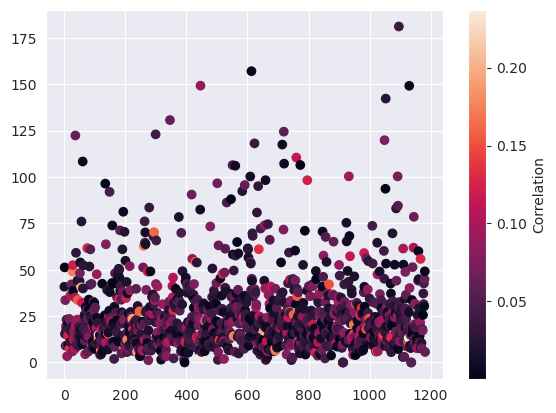

In [4]:
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
COPDGene_SOMASCAN13 = pd.read_csv('/home/shussein/NetCO/data/SOMASCAN13/COPDGene_SOMASCAN13_subjects.csv')
# COPDGene_SOMASCAN13 = pd.read_csv('/home/shussein/NetCO/SubjectRepresentationScripts/SubjectRepresentationOneModel/after_training.csv')
X = COPDGene_SOMASCAN13.loc[:,COPDGene_SOMASCAN13.columns != 'finalgold_visit']
Y = COPDGene_SOMASCAN13['finalgold_visit']
corr = X.corrwith(Y).abs()
plt.scatter(range(0, 1183), [k for _, k in ppi_network.degree(weight='weight')], c=corr.tolist())
plt.colorbar(label='Correlation')


In [5]:
print(laplacian_matrix[[0],:])

  (0, 0)	40.831038353729284
  (0, 12)	-0.600952979989618
  (0, 27)	-0.70543703002996
  (0, 28)	-0.690047281675029
  (0, 36)	-0.655495954951734
  (0, 53)	-0.681401256969015
  (0, 60)	-0.641234720491029
  (0, 75)	-0.653867277983556
  (0, 107)	-0.734802749176414
  (0, 108)	-0.70139678390526
  (0, 208)	-0.692412091732251
  (0, 210)	-0.576772422093982
  (0, 211)	-0.645255645581738
  (0, 235)	-0.612530908374409
  (0, 260)	-0.719194354719332
  (0, 283)	-0.612319785856408
  (0, 360)	-0.689140117013229
  (0, 386)	-0.675643972690463
  (0, 387)	-0.61798278622003
  (0, 388)	-0.665179960295237
  (0, 429)	-0.620515577803337
  (0, 501)	-0.705932445943037
  (0, 518)	-0.686714686804675
  (0, 521)	-0.664725864647684
  (0, 546)	-0.750800857249305
  :	:
  (0, 752)	-0.547354402073368
  (0, 756)	-0.629453406108015
  (0, 758)	-0.598560597708333
  (0, 759)	-0.613082934779016
  (0, 760)	-0.657722297041525
  (0, 846)	-0.76315717206644
  (0, 879)	-0.661617814661894
  (0, 910)	-0.581347733752706
  (0, 936)	-0.695

In [6]:
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.data import Data
import pandas as pd
import networkx as nx
import numpy as np
import torch

ppi_network_adj = pd.read_csv('/home/shussein/NetCO/data/PPI_Yong/ppi_graph_1183_mRNA_updated_root_2656sub.csv', delimiter='\t')
# ppi_network_adj = pd.read_csv('/home/storage/husssund/data/ppi_graph_1183_mRNA_updated_root_2656sub.csv', delimiter='\t')
nodes_names = ppi_network_adj.columns.tolist()
ppi_network = nx.from_numpy_array(ppi_network_adj.to_numpy())


nodes_features = []
for node_idx, node_name in enumerate(nodes_names):
    node_features = [1] # [node_idx]
    nodes_features.append(node_features)

features = np.array(nodes_features)
ppi_network.remove_edges_from(nx.selfloop_edges(ppi_network))

x = np.zeros(features.shape)
graph_nodes = list(ppi_network.nodes)
for m in range(features.shape[0]):
    x[graph_nodes[m]] = features[m]
x = torch.from_numpy(x).float()

# Edges Indexes
edge_index = np.array(list(ppi_network.edges))
edge_index = np.concatenate((edge_index, edge_index[:, ::-1]), axis=0)
edge_index = torch.from_numpy(edge_index).long().permute(1, 0)

# Edges Weights
edge_weight = np.array(list(nx.get_edge_attributes(ppi_network, 'weight').values()))
edge_weight = np.concatenate((edge_weight, edge_weight), axis=0)
edge_weight = torch.from_numpy(edge_weight).float()

dataset = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=torch.zeros(len(nodes_names)))

transform = RandomNodeSplit(num_val=100, num_test=200)
data = transform(dataset)
data

Data(x=[1183, 1], edge_index=[2, 45640], edge_attr=[45640], y=[1183], train_mask=[1183], val_mask=[1183], test_mask=[1183])

Data(x=[1183, 1], edge_index=[2, 45640], edge_attr=[45640], y=[1183], train_mask=[1183], val_mask=[1183], test_mask=[1183])
True
True
Epoch: 001, Loss: 3.2413
Epoch: 002, Loss: 2.8403
Epoch: 003, Loss: 2.5171
Epoch: 004, Loss: 2.2604
Epoch: 005, Loss: 2.0612
Epoch: 006, Loss: 1.9044
Epoch: 007, Loss: 1.7856
Epoch: 008, Loss: 1.6904
Epoch: 009, Loss: 1.6117
Epoch: 010, Loss: 1.5452
Epoch: 011, Loss: 1.4879
Epoch: 012, Loss: 1.4409
Epoch: 013, Loss: 1.4066
Epoch: 014, Loss: 1.3790
Epoch: 015, Loss: 1.3581
Epoch: 016, Loss: 1.3438
Epoch: 017, Loss: 1.3291
Epoch: 018, Loss: 1.3199
Epoch: 019, Loss: 1.3112
Epoch: 020, Loss: 1.3040
Epoch: 021, Loss: 1.2979
Epoch: 022, Loss: 1.2925
Epoch: 023, Loss: 1.2884
Epoch: 024, Loss: 1.2834
Epoch: 025, Loss: 1.2803
Epoch: 026, Loss: 1.2768
Epoch: 027, Loss: 1.2742
Epoch: 028, Loss: 1.2709
Epoch: 029, Loss: 1.2690
Epoch: 030, Loss: 1.2670
Epoch: 031, Loss: 1.2648
Epoch: 032, Loss: 1.2630
Epoch: 033, Loss: 1.2606
Epoch: 034, Loss: 1.2591
Epoch: 035, Loss

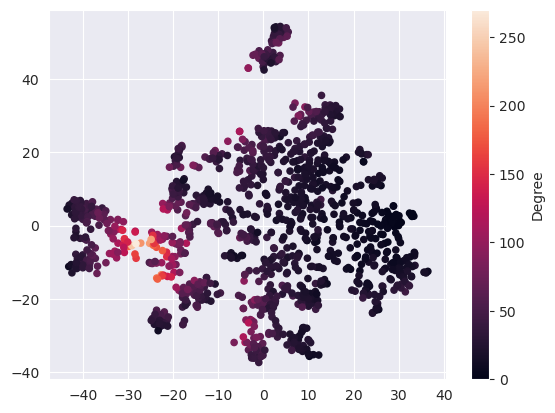

In [7]:
import os.path as osp
import sys

import matplotlib.pyplot as plt
import torch
import torch_geometric
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

# path = osp.join('..', 'data', 'Planetoid')
# dataset = Planetoid(path, name='Cora')
# data = dataset[0]
print(data)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    data.edge_index,
    embedding_dim=16,
    walk_length=32,
    context_size=10,
    walks_per_node=50,
    num_negative_samples=10,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

num_workers = 4 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        # print(pos_rw)
        # print(neg_rw)
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc


for epoch in range(1, 101):
    loss = train()
    # acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}') #, Acc: {acc:.4f}')


# @torch.no_grad()
# def plot_points(colors):
#     model.eval()
#     z = model().cpu().numpy()
#     z = TSNE(n_components=2).fit_transform(z)
#     y = data.y.cpu().numpy()
# 
#     plt.figure(figsize=(8, 8))
#     for i in range(dataset.num_classes):
#         plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
#     plt.axis('off')
#     plt.show()


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    degrees = []
    for n in ppi_network.nodes():
        degrees.append(ppi_network.degree(n))

    plt.scatter(z[:, 0], z[:, 1], s=20, c=degrees)
    plt.colorbar(label='Degree')
    # 
    # y = data.y.cpu().numpy()
    # 
    # plt.figure(figsize=(8, 8))
    # for i in range(dataset.num_classes):
    #     plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    # plt.axis('off')
    # plt.show()
# 
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)

In [8]:
@torch.no_grad()
def eval():
    model.eval()
    z = model().cpu().numpy()
    print(z.shape)
    return z
z = eval()
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(z)
cosine_sim

(1183, 16)


array([[ 0.9999999 ,  0.2965756 , -0.1114191 , ...,  0.268965  ,
         0.2980215 , -0.48924193],
       [ 0.2965756 ,  0.99999994,  0.60130537, ...,  0.76442397,
         0.75446063, -0.5470946 ],
       [-0.1114191 ,  0.60130537,  0.9999998 , ...,  0.55717784,
         0.5895065 , -0.3390004 ],
       ...,
       [ 0.268965  ,  0.76442397,  0.55717784, ...,  1.        ,
         0.58708996, -0.32722577],
       [ 0.2980215 ,  0.75446063,  0.5895065 , ...,  0.58708996,
         1.        , -0.5852956 ],
       [-0.48924193, -0.5470946 , -0.3390004 , ..., -0.32722577,
        -0.5852956 ,  0.9999999 ]], dtype=float32)

In [30]:
# num_nodes = 1183
# 
# # Generate a meshgrid of row and column indices
# row_indices, col_indices = np.meshgrid(np.arange(num_nodes), np.arange(num_nodes))
# 
# # Create a matrix with unique values based on the combination of row and column indices
# unique_matrix = row_indices * 1000 + col_indices
# 
# # Display the unique matrix
# from sklearn.preprocessing import normalize
# 
# # Normalize the matrix
# cosine_sim = normalize(unique_matrix, axis=1, norm='l2')
# cosine_sim

num_nodes = 1183
embedding_dim = 100
node_embeddings = np.random.rand(num_nodes, embedding_dim)

# Compute cosine similarity between node embeddings
cosine_sim = cosine_similarity(node_embeddings)

In [19]:
import random
import torch
# import torchmetrics
import torch.nn.functional as F

# Set seeds for Python, Numpy, and PyTorch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multiple GPUs
np.random.seed(seed)
random.seed(seed)
import scipy
print(scipy.__version__)
# Set deterministic behavior for cudnn (if using CUDA)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# from torcheval.metrics.functional import multiclass_f1_score
from torchmetrics.classification import MulticlassF1Score

# from torchmetrics.classification import MulticlassConfusionMatrix


# Define the linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)
        # y_pred = torch.sigmoid(self.linear(x))
        # return y_pred

# Define the graph Laplacian regularization loss
class GraphRegularizationLoss(nn.Module):
    def __init__(self, adjacency_matrix, lambda_reg):
        super(GraphRegularizationLoss, self).__init__()
        self.adjacency_matrix = adjacency_matrix
        # self.laplacian_matrix = laplacian_matrix
        self.lambda_reg = lambda_reg

    def forward(self, weights_matrix):
        # L = torch.sum(self.adjacency_matrix * torch.norm(node_embeddings.unsqueeze(1) - node_embeddings.unsqueeze(0), dim=2)**2)
        # L = torch.sum(self.adjacency_matrix * torch.abs(weights_matrix.t()))
        # return self.lambda_reg * L

        # Multiple Classes
        loss_reg = 0
        for weight_vector in weights_matrix:
            L = torch.sum(self.adjacency_matrix * torch.abs(weight_vector))
            loss_reg += L

        return self.lambda_reg * loss_reg
        # loss_reg = 0
        # for weight_vector in weights_matrix:
        #     # L = torch.trace(torch.mm(torch.mm(weight_matrix.t(), self.laplacian_matrix), weight_matrix))
        #     # L = torch.sum(self.laplacian_matrix * torch.abs(weight_matrix))
        #     L = torch.sum(torch.abs(self.laplacian_matrix * weight_vector.view(-1, 1)))
        #     # print("L %s" % L)
        #     loss_reg += L
        # return self.lambda_reg * loss_reg

# COPDGene SOMASCAN 1.3 Datset
# COPDGene_SOMASCAN13 = pd.read_csv('/home/storage/husssund/data/COPDGene_SOMASCAN13_subjects.csv')
X = COPDGene_SOMASCAN13.loc[:,COPDGene_SOMASCAN13.columns != 'finalgold_visit']
y = COPDGene_SOMASCAN13['finalgold_visit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.to_numpy())
X_test_scaled = scaler.fit_transform(X_test.to_numpy())

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# adjacency_matrix = torch.tensor(pd.read_csv('../data/PPI_Yong/ppi_graph_1183_mRNA_updated_root_2656sub.csv', delimiter='\t').to_numpy(),
#                                 dtype=torch.float32)
# degree_matrix = torch.sum(adjacency_matrix, dim=1)
# degree_matrix_sqrt_inv = torch.diag(torch.pow(degree_matrix, -0.5))
# laplacian_matrix = torch.eye(adjacency_matrix.size(0)) - degree_matrix_sqrt_inv.matmul(adjacency_matrix).matmul(degree_matrix_sqrt_inv)
# print(laplacian_matrix)

adjacency_matrix = pd.read_csv('../data/PPI_Yong/ppi_graph_1183_mRNA_updated_root_2656sub.csv', delimiter='\t')
# adjacency_matrix = pd.read_csv('/home/storage/husssund/data/ppi_graph_1183_mRNA_updated_root_2656sub.csv', delimiter='\t')
ppi_network = nx.from_numpy_array(adjacency_matrix.to_numpy())
laplacian_matrix = nx.laplacian_matrix(ppi_network)
# print(laplacian_matrix.todense())

# Hyperparameters
input_size = X_train_tensor.shape[1]
output_size = 3
lambda_reg = 0.001
learning_rate = 0.01
num_epochs = 300

# Instantiate the model and loss function
model = LinearRegression(input_size, output_size)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
graph_reg_loss = GraphRegularizationLoss(adjacency_matrix, lambda_reg)

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)#.flatten()
    loss = criterion(outputs, y_train_tensor)

    # Add L2 regularization to the bias terms
    # l2_regularization = 0
    # for name, param in model.named_parameters():
    #     if 'bias' in name:
    #         l2_regularization += torch.norm(param, p=2)  # L2 norm of bias
    # loss += 0.001 * l2_regularization

    # Compute graph regularization loss
    weights = model.linear.weight

    # L1 Regularization
    l1_regularization = weights.abs().sum()
    # print("L1 Regularization:", l1_regularization)

    # L1 Regularization
    l2_regularization = weights.pow(2).sum()
    # print("L2 Regularization:", l2_regularization)
    
    # Elastic Net
    elastic_net_regularization = 0.01 * l1_regularization + 0.01 * l2_regularization
    # print("Elastic Net Regularization:", elastic_net_regularization)
    
    
    # Laplacian Regularization
    laplacian_tensor = torch.tensor(laplacian_matrix.toarray(), dtype=torch.float32)
    laplacian_regularization = torch.trace(torch.matmul(torch.matmul(model.linear.weight, laplacian_tensor), model.linear.weight.t()))
    # print("Laplacian Regularization %s" % laplacian_regularization)
    
    # Adjacency Regularization
    adjacency_tensor = torch.tensor(adjacency_matrix.to_numpy(), dtype=torch.float32)
    # adjacency_regularization = torch.sum(torch.mul(adjacency_tensor, (model.linear.weight.T - model.linear.weight)**2))

    # adjacency_regularization = []
    # for class_idx in range(3):
    #     # Calculate penalty term for current class
    #     penalty_term_class = lambda_reg * torch.sum(torch.matmul(adjacency_tensor, (model.linear.weight[class_idx].T - model.linear.weight[class_idx])**2))
    #     adjacency_regularization.append(penalty_term_class)
    # 
    # # Sum up penalty terms for all classes
    # adjacency_regularization = torch.sum(torch.stack(adjacency_regularization))
    
    # Cosine Similarity Regularization - Embeddings using Node2Vec
    cosine_sim_tensor = torch.tensor(cosine_sim, dtype=torch.float32)
    cosine_sim_regularization = torch.trace(torch.matmul(torch.matmul(model.linear.weight, cosine_sim_tensor), model.linear.weight.t()))
    # print("Cosine Similarity Regularization %s" % cosine_sim_regularization)
    
    # Another Approach for Cosine Similarity Regularization
    # Define similarity threshold
    similarity_threshold = 0.5  # Adjust this threshold based on your specific requirements

    # Compute penalty term
    penalty_term = 0.01 * torch.sum(torch.mul(adjacency_tensor, (torch.max(cosine_sim_tensor - similarity_threshold, torch.zeros_like(cosine_sim_tensor)))**2))


# Weights (Adjacency) Regularization
    # _, predicted_labels = torch.max(outputs, 1)
    # penalty_term = torch.tensor(0.0)
    # for i in range(X_train_tensor.shape[0]):
    #     for j in range(X_train_tensor.shape[0]):
    #         # kl_div = F.kl_div(outputs[i].log(), outputs[j], reduction='sum')
    #         # print("kl_div", kl_div)
    #         penalty_term += adjacency_matrix.to_numpy()[i, j] * torch.abs(predicted_labels[i] - predicted_labels[j])
    # print("Penalty term: ", penalty_term)

    
    # loss += 0.01 * laplacian_regularization
    loss += penalty_term #  + elastic_net_regularization)
    # loss += (0.001 * l1_regularization + 0.01 * laplacian_regularization)
    # loss_reg = graph_reg_loss(model.linear.weight)

    # Total loss
    # total_loss = loss_task # + loss_reg

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Task Loss: {loss.item():.4f}') #, Graph Regularization Loss: {loss_reg.item():.4f}')

# Print the Indicies of the Top 10 Contributing Features

top_indices = np.argsort(-np.array(weights.detach().numpy()))[:, 0:10]
print("Top 10 Task Weights: %s" % top_indices)

# Evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)#.detach().numpy()
    # print(outputs)
    # print("Predicted %s" % outputs)

    # predicted_probs = torch.softmax(outputs, dim=1)
    _, predicted_labels = torch.max(outputs, 1)
    # print(predicted_labels)
    accuracy = torch.sum(predicted_labels == y_test_tensor).item() / len(y_test)
    mse = nn.MSELoss()(predicted_labels, y_test_tensor.float())
    print("accuracy: {:.4f}".format(accuracy))
    print(f'Mean Squared Error: {mse:.4f}')
    # f1 = multiclass_f1_score(predicted_labels, y_test_tensor, num_classes=3)
    f1 = MulticlassF1Score(num_classes=output_size, average=None)(predicted_labels, y_test_tensor)
    print("f1 score: %s" % f1)
    
    
# Top Weights Indexes - No Regularization
# Top 10 Task Weights: [[ 858 1127  970   17  147  952  283  433  364  171]
#                       [  72  713  522  765  199  111  630  518 1024  339]
# [1128 1126  444  158  222  208  319 1032  694  392]]
# accuracy: 0.5476
# Mean Squared Error: 0.7262

# - With Laplacian Regularization: 0.1
# Top 10 Task Weights: [[ 913   17  394 1023  238  283  748  744 1137  844]
#                       [ 912  913  358  394  247 1136  249 1114  954  558]
# [ 444 1137  317  392  523  335  256  333   77 1128]]
# - With Laplacian Regularization: 0.01
# Top 10 Task Weights: [[  17  858  283 1127  206  473  952  364  433 1023]
#                       [ 247  358  522  199  713    9  868  726  111  249]
# [ 444 1128 1126  392  158  208  222  256  504  111]]
# accuracy: 0.5714
# Mean Squared Error: 0.6429

# With Cosine Similarity Regularizarion 0.1 - Based on Node2Vec
# Top 10 Task Weights: [[1127  858   17  147  952  970  283  880  876 1068]
#                       [  72  713  522  199  630  116  765  518  371 1024]
# [1128 1126  444  158  208  974  319  222   20 1032]]
# accuracy: 0.5714
# Mean Squared Error: 0.6667

# With L1 Regularization 0.01
# Top 10 Task Weights: [[ 970  858   17  952 1127  880  283  433  147 1113]
#                       [ 713   72 1024  518  522  765  111  548  199  247]
# [1128  444  158 1126  208  319  222  439 1032  729]]
# accuracy: 0.5675
# Mean Squared Error: 0.6468

# L2 Regularization 0.01
# Top 10 Task Weights: [[ 858 1127  970   17  147  952  283  364  433  171]
#                       [  72  713  522  765  199  111  630  518 1024  339]
# [1128 1126  444  158  222  208  319 1032  694  392]]
# accuracy: 0.5556
# Mean Squared Error: 0.6944

# Elastic Net Regularization 0.01 L1 + 0.01 L2
# Top 10 Task Weights: [[ 970   17  858  952 1127  880  283  433  147  743]
#                       [ 713   72 1024  518  522  765  111  548  199  247]
# [1128  444  158 1126  208  319  222  439 1032  729]]
# accuracy: 0.5675
# Mean Squared Error: 0.6468
# f1 score: tensor([0.6942, 0.4485, 0.4536])

# All Three
# Elastic Net + Laplacian + Cosine - Elastic + Laplacian -> Same MSE but lower F1 for Class 2 & higher F1 for Class 1 
#                                    Elastic + Cosine -> Higher MSE (0.6548) and higher F1 for Class 1 & 2 (0.04540 and 0.4490)
# Top 10 Task Weights: [[  17  283  858  206 1023  844  970  743  653  952]
#                       [ 247  713  358   14  522  199  751  966  912 1013]
# [ 444 1128 1126  158  208 1046  256  392 1100  112]]
# accuracy: 0.5714
# Mean Squared Error: 0.6071
# f1 score: tensor([0.7109, 0.4294, 0.4235])

1.11.4
Epoch [10/300], Task Loss: 16.2837
Epoch [20/300], Task Loss: 16.1724
Epoch [30/300], Task Loss: 16.0942
Epoch [40/300], Task Loss: 16.0334
Epoch [50/300], Task Loss: 15.9835
Epoch [60/300], Task Loss: 15.9413
Epoch [70/300], Task Loss: 15.9049
Epoch [80/300], Task Loss: 15.8729
Epoch [90/300], Task Loss: 15.8446
Epoch [100/300], Task Loss: 15.8192
Epoch [110/300], Task Loss: 15.7963
Epoch [120/300], Task Loss: 15.7755
Epoch [130/300], Task Loss: 15.7565
Epoch [140/300], Task Loss: 15.7390
Epoch [150/300], Task Loss: 15.7229
Epoch [160/300], Task Loss: 15.7079
Epoch [170/300], Task Loss: 15.6940
Epoch [180/300], Task Loss: 15.6810
Epoch [190/300], Task Loss: 15.6688
Epoch [200/300], Task Loss: 15.6574
Epoch [210/300], Task Loss: 15.6467
Epoch [220/300], Task Loss: 15.6366
Epoch [230/300], Task Loss: 15.6270
Epoch [240/300], Task Loss: 15.6179
Epoch [250/300], Task Loss: 15.6093
Epoch [260/300], Task Loss: 15.6011
Epoch [270/300], Task Loss: 15.5933
Epoch [280/300], Task Loss: 15

In [60]:
# predicted_labels.view(predicted_labels.shape[0], 1, 1183)
# torch.tensor(adjacency_matrix.to_numpy()).view(1, -1, 1183)
# abs_diff = torch.abs(predicted_labels.unsqueeze(1) - predicted_labels.unsqueeze(2))
predicted_labels.unsqueeze()

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [42]:
adjacency_matrix.to_numpy()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.65243454, ..., 0.7574286 , 0.        ,
        0.        ],
       [0.        , 0.65243454, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.7574286 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [70]:
weights

Parameter containing:
tensor([[ 4.8233e-04,  7.9712e-04, -5.0668e-04,  ..., -2.0430e-04,
         -1.4673e-03, -1.6663e-02],
        [-1.7461e-03, -6.6978e-05,  8.7932e-04,  ...,  1.0326e-03,
          1.7523e-03, -3.0153e-03],
        [ 3.7116e-04, -1.6357e-03, -1.2836e-03,  ..., -1.7485e-03,
         -1.2111e-03,  1.8893e-02]], requires_grad=True)

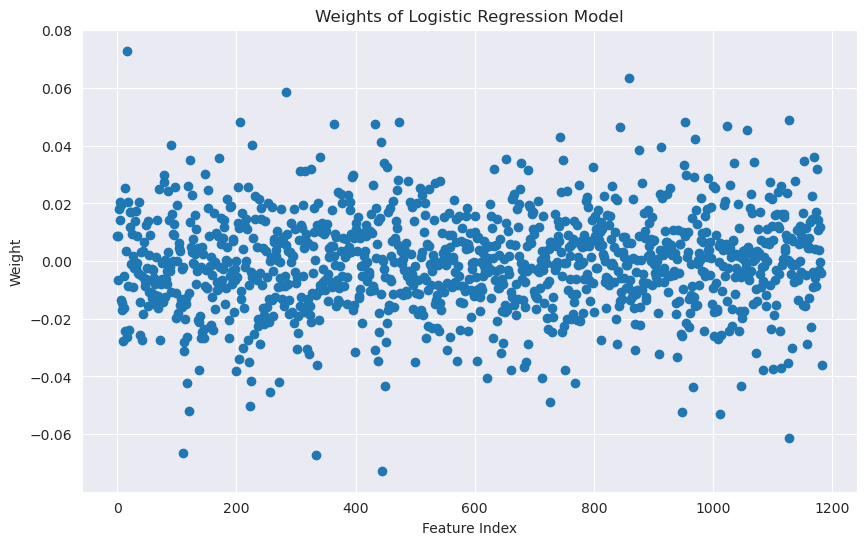

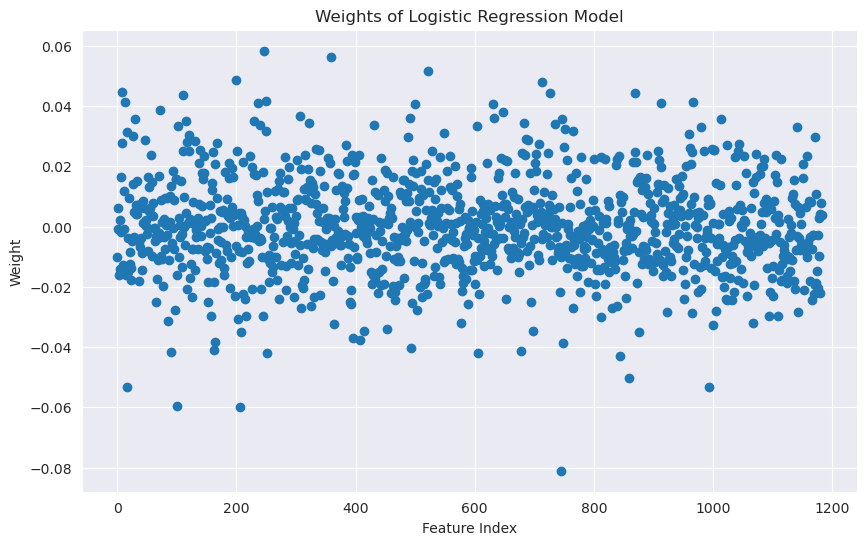

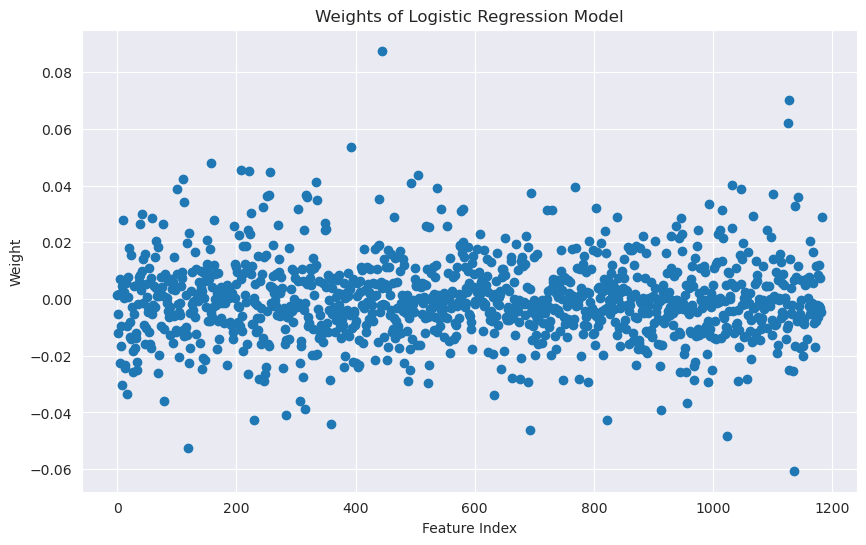

In [84]:
# Plot the weights
for weight in weights:
    weight = weight.detach().numpy()
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(weight)), weight)
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.title('Weights of Logistic Regression Model')
    plt.show()

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss

COPDGene_SOMASCAN13 = pd.read_csv('/home/shussein/NetCO/data/SOMASCAN13/COPDGene_SOMASCAN13_subjects.csv')
# COPDGene_SOMASCAN13 = pd.read_csv('/home/shussein/NetCO/SubjectRepresentationScripts/SubjectRepresentationOneModel/after_training.csv')
X = COPDGene_SOMASCAN13.loc[:,COPDGene_SOMASCAN13.columns != 'finalgold_visit']
Y = COPDGene_SOMASCAN13['finalgold_visit']
corr = X.corrwith(Y).abs().sort_values(ascending=False)

top_corr = corr[0:80].index.tolist()
# X = X[top_corr]
columns = X.columns

scaler = MinMaxScaler()
scaler.fit(X)
original_dataset_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(original_dataset_scaled, Y, test_size=0.3, random_state=42)
logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
# # define the model evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate the model and collect the scores
# n_scores = cross_val_score(logistic_regression, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# # report the model performance
# print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
logistic_regression.fit(X_train, y_train)
# train_losses = []
# test_losses = []
# # Training loop
# for epoch in range(50):
#     # Train the model
#     logistic_regression.fit(X_train, y_train)
# 
#     # Predict probabilities on training and testing data
#     train_probs = logistic_regression.predict_proba(X_train)
#     test_probs = logistic_regression.predict_proba(X_test)
# 
#     # # Compute training and testing loss
#     # train_loss = log_loss(y_train, train_probs)
#     # test_loss = log_loss(y_test, test_probs)
#     train_loss = logistic_regression.loss_
#     test_loss = logistic_regression.loss_
# 
#     # Store the loss values
#     train_losses.append(train_loss)
#     test_losses.append(test_loss)
# 
#     # Print loss for each epoch
#     print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Testing Loss: {test_loss}")
# 
# # Plot the training and testing loss over epochs
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 50 + 1), train_losses, label='Training Loss', color='blue')
# plt.plot(range(1, 50 + 1), test_losses, label='Testing Loss', color='orange')
# plt.xlabel('Epoch')
# plt.ylabel('Log Loss')
# plt.title('Training and Testing Loss over Epochs for Logistic Regression')
# plt.legend()
# plt.show()

print("Training Accuracy %s" % logistic_regression.score(X_train, y_train))
pred = logistic_regression.predict(X_test)
print("Testing Accuracy %s" % accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
print(logistic_regression.coef_)

top_indices = np.argsort(logistic_regression.coef_)[:, 0:10]
print(top_indices)

Training Accuracy 0.9538461538461539
Testing Accuracy 0.5674603174603174
              precision    recall  f1-score   support

         0.0       0.61      0.77      0.68       109
         1.0       0.49      0.41      0.45        91
         2.0       0.56      0.42      0.48        52

    accuracy                           0.57       252
   macro avg       0.56      0.53      0.54       252
weighted avg       0.56      0.57      0.55       252

[[ 0.17782755  0.14452465  0.01010273 ...  0.04182023 -0.23279162
  -0.26164188]
 [-0.19670607  0.05106243  0.04152392 ...  0.29457261  0.16293427
  -0.07292092]
 [ 0.01887852 -0.19558708 -0.05162665 ... -0.33639284  0.06985735
   0.33456281]]
[[ 948  111  223  726  713  444  333 1012  621  518]
 [ 993  532  744  206  215  208  493  677   17  831]
 [ 676  357  279 1023  219   55 1136  955   27  358]]


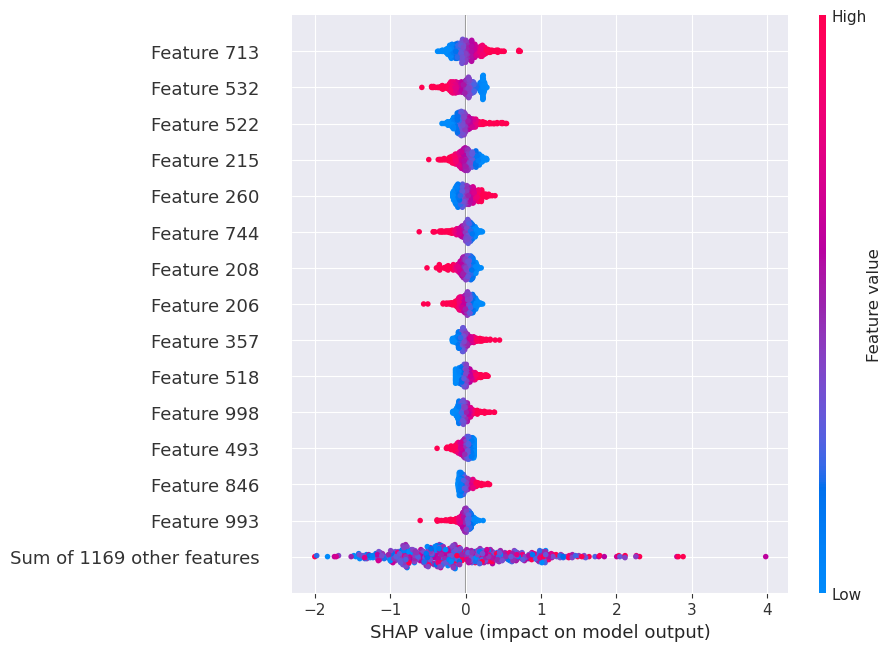

In [64]:
import shap

explainer = shap.Explainer(logistic_regression, X_train)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values[:,:,1], max_display=15)
# shap_values.shape

In [157]:
# Add code for correlation between features and the target variable
corr = X.corrwith(Y).abs().sort_values(ascending=False)
corr

['TNNT2',
 'FUT5',
 'C9',
 'GHR',
 'KLKB1',
 'APOA1',
 'CHRDL1',
 'CNDP1',
 'SERPINA4',
 'GDF15',
 'LRIG3',
 'CDON',
 'IGFBP2',
 'AGT',
 'REN',
 'LRP1B',
 'CRP',
 'MED1',
 'CA6',
 'CCL14']

(array([392., 352., 196., 115.,  68.,  24.,  17.,  11.,   5.,   3.]),
 array([4.66652326e-05, 2.37551002e-02, 4.74635352e-02, 7.11719702e-02,
        9.48804051e-02, 1.18588840e-01, 1.42297275e-01, 1.66005710e-01,
        1.89714145e-01, 2.13422580e-01, 2.37131015e-01]),
 <BarContainer object of 10 artists>)

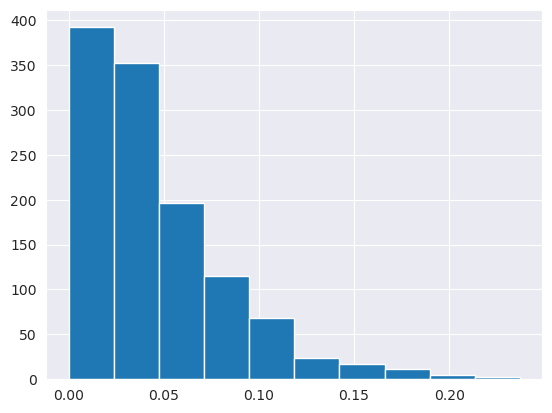

In [126]:
plt.hist(corr)

['TNNT2',
 'FUT5',
 'C9',
 'GHR',
 'KLKB1',
 'APOA1',
 'CHRDL1',
 'CNDP1',
 'SERPINA4',
 'GDF15']

In [125]:
columns_map = dict(zip(X.columns.tolist(), range(0, len(X.columns))))
columns_map

{'A2M': 0,
 'ABL1': 1,
 'ABL2': 2,
 'ACAN': 3,
 'ACE2': 4,
 'ACP1': 5,
 'ACP5': 6,
 'ACVR1B': 7,
 'ACVRL1': 8,
 'ACY1': 9,
 'ADAM12': 10,
 'ADAM9': 11,
 'ADAMTS1': 12,
 'ADAMTS13': 13,
 'ADAMTS15': 14,
 'ADAMTS4': 15,
 'ADAMTS5': 16,
 'ADGRE2': 17,
 'ADGRE5': 18,
 'ADGRG5': 19,
 'ADIPOQ': 20,
 'ADM': 21,
 'ADSL': 22,
 'AFP': 23,
 'AGER': 24,
 'AGR2': 25,
 'AGRP': 26,
 'AGT': 27,
 'AHSG': 28,
 'AIF1': 29,
 'AIMP1': 30,
 'AIP': 31,
 'AK1': 32,
 'AKR1A1': 33,
 'AKR7A2': 34,
 'AKT2': 35,
 'ALB': 36,
 'ALCAM': 37,
 'ALDOA': 38,
 'AMH': 39,
 'AMIGO2': 40,
 'AMN': 41,
 'ANG': 42,
 'ANGPT1': 43,
 'ANGPT2': 44,
 'ANGPT4': 45,
 'ANGPTL3': 46,
 'ANGPTL4': 47,
 'ANK2': 48,
 'ANP32B': 49,
 'ANXA1': 50,
 'ANXA2': 51,
 'ANXA5': 52,
 'ANXA6': 53,
 'APCS': 54,
 'APOA1': 55,
 'APOB': 56,
 'APOD': 57,
 'APOL1': 58,
 'APOM': 59,
 'APP': 60,
 'AREG': 61,
 'ARG1': 62,
 'ARID3A': 63,
 'ARPP19': 64,
 'ARSA': 65,
 'ARSB': 66,
 'ARTN': 67,
 'ASAH2': 68,
 'ASGR1': 69,
 'ATP5F1B': 70,
 'ATP5PO': 71,
 'AURKA': 72,

In [142]:
# Indicies of Highly Correlated Omics
top_corr_indices = [columns_map[x] for x in corr[0:20].index.tolist()]
top_corr_indices

[1128,
 444,
 112,
 462,
 653,
 55,
 223,
 238,
 991,
 451,
 690,
 206,
 554,
 27,
 948,
 692,
 260,
 737,
 119,
 142]

(array([6.000e+00, 3.000e+01, 1.480e+02, 4.650e+02, 1.758e+03, 5.073e+03,
        8.023e+03, 5.598e+03, 1.642e+03, 7.700e+01]),
 array([0.25052565, 0.31940133, 0.388277  , 0.45715267, 0.52602834,
        0.59490401, 0.66377968, 0.73265536, 0.80153103, 0.8704067 ,
        0.93928237]),
 <BarContainer object of 10 artists>)

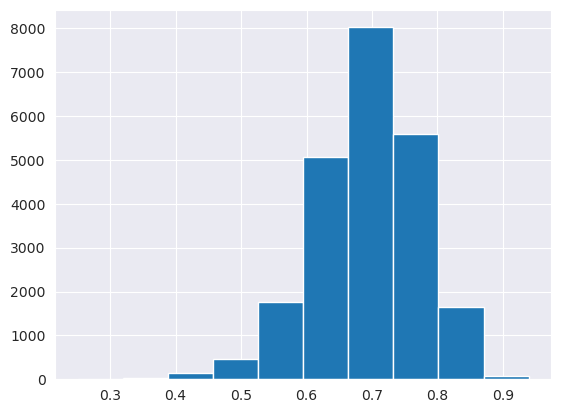

In [115]:
import networkx as nx
import matplotlib.pyplot as plt
ppi_network = nx.from_numpy_array(pd.read_csv('../data/PPI_Yong/ppi_graph_1183_mRNA_updated_root_2656sub.csv', delimiter='\t').to_numpy())
weights = [d['weight'] for u, v, d in ppi_network.edges(data=True)]

plt.hist(weights)

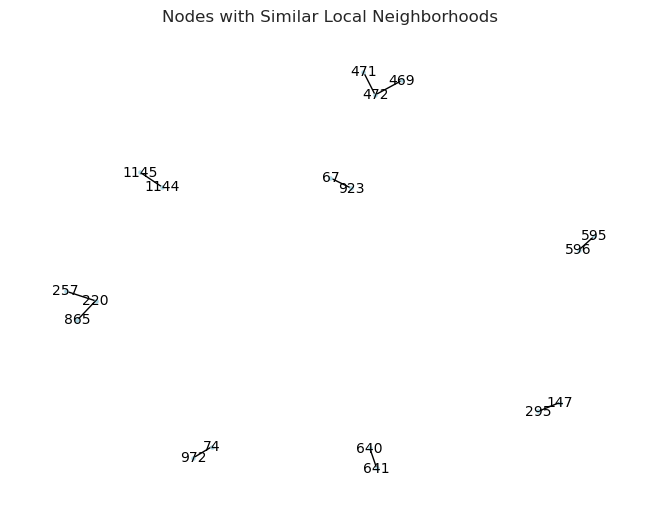

In [233]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to calculate Jaccard similarity between neighbors
def jaccard_similarity(G, node1, node2):
    neighbors1 = set(G.neighbors(node1))
    neighbors2 = set(G.neighbors(node2))
    intersection = neighbors1.intersection(neighbors2)
    union = neighbors1.union(neighbors2)
    if len(union) == 0:
        return 0
    else:
        return len(intersection) / len(union)

# Calculate similarity between nodes
node_similarities = {}
for node1 in ppi_network.nodes():
    for node2 in ppi_network.nodes():
        if node1 != node2:
            similarity = jaccard_similarity(ppi_network, node1, node2)
            if similarity > 0:
                node_similarities[(node1, node2)] = similarity

# Threshold for similarity
threshold = 0.5  # adjust this threshold as needed

# Create a new graph with edges only between similar nodes
H = nx.Graph()
for (node1, node2), similarity in node_similarities.items():
    if similarity >= threshold:
        H.add_edge(node1, node2)

# Visualize the graph
pos = nx.spring_layout(H)  # You can use any layout algorithm here
nx.draw(H, pos, with_labels=True, node_color='lightblue', node_size=5, font_size=10)
plt.title('Nodes with Similar Local Neighborhoods')
plt.show()


In [275]:
from torch_geometric.data import Data
ppi_network_adj = pd.read_csv('/home/shussein/NetCO/data/PPI_Yong/ppi_graph_1183_mRNA_updated_root_2656sub.csv', delimiter='\t')
nodes_names = ppi_network_adj.columns.tolist()
ppi_network = nx.from_numpy_array(ppi_network_adj.to_numpy())

COPDGene_SOMASCAN13_dataset = pd.read_csv('/home/shussein/NetCO/data/SOMASCAN13/COPDGene_SOMASCAN13_subjects.csv', index_col=None)

nodes_features = []
for node_idx, node_name in enumerate(nodes_names):
    node_features = [node_idx]
    nodes_features.append(node_features)

features = np.array(nodes_features)
print(features)
ppi_network.remove_edges_from(nx.selfloop_edges(ppi_network))

x = np.zeros(features.shape)
graph_nodes = list(ppi_network.nodes)
for m in range(features.shape[0]):
    x[graph_nodes[m]] = features[m]
x = torch.from_numpy(x).float()

# Edges Indexes
edge_index = np.array(list(ppi_network.edges))
edge_index = np.concatenate((edge_index, edge_index[:, ::-1]), axis=0)
edge_index = torch.from_numpy(edge_index).long().permute(1, 0)

# Edges Weights
edge_weight = np.array(list(nx.get_edge_attributes(ppi_network, 'weight').values()))
edge_weight = np.concatenate((edge_weight, edge_weight), axis=0)
edge_weight = torch.from_numpy(edge_weight).float()

dataset = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=torch.zeros(len(nodes_names)))

transform = RandomNodeSplit(num_val=100, num_test=200)
data = transform(dataset)
data


[[   0]
 [   1]
 [   2]
 ...
 [1180]
 [1181]
 [1182]]


Data(x=[1183, 1], edge_index=[2, 45640], edge_attr=[45640], y=[1183], train_mask=[1183], val_mask=[1183], test_mask=[1183])

In [271]:
from torch_geometric.transforms import RandomNodeSplit
# Graph Autoencoder
import argparse
import os.path as osp
import time



import torch

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GAE, VGAE, GCNConv


if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
print(device)

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class LinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)


class VariationalLinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_mu = GCNConv(in_channels, out_channels)
        self.conv_logstd = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

print(data)
print(data.x)
data = data.to(device)

in_channels, out_channels = dataset.num_features, 16
print("Input Channels %s\tOutput Channels %s" % (in_channels,out_channels))

variational = False
linear = False
if not variational and not linear:
    model = GAE(GCNEncoder(in_channels, out_channels))
elif not variational and linear:
    model = GAE(LinearEncoder(in_channels, out_channels))
elif variational and linear:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
elif variational and linear:
    model = VGAE(VariationalLinearEncoder(in_channels, out_channels))

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

data.pos_edge_label_index = data.edge_index
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    # print("Z %s" % z)
    # print(z.shape)
    loss = model.recon_loss(z, data.pos_edge_label_index)
    if variational:
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    print("Training Loss %s" % loss.item())
    return float(loss), z


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


times = []
epochs = 1000
for epoch in range(1, epochs + 1):
    start = time.time()
    loss, z = train()
    # auc, ap = test(data)
    # print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    # times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")
print(z)

cuda
[[   0]
 [   1]
 [   2]
 ...
 [1180]
 [1181]
 [1182]]
Data(x=[1183, 1], edge_index=[2, 45640], edge_attr=[45640], y=[1183], train_mask=[1183], val_mask=[1183], test_mask=[1183])
tensor([[0.0000e+00],
        [1.0000e+00],
        [2.0000e+00],
        ...,
        [1.1800e+03],
        [1.1810e+03],
        [1.1820e+03]])
Input Channels 1	Output Channels 16
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.53877258300781
Training Loss 34.5387725830

In [294]:
import torch.nn.functional as F
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_num=2, dropout=True, **kwargs):
        super(GCN, self).__init__()
        self.layer_num = layer_num
        self.dropout = dropout
        self.conv_first = GCNConv(input_dim, hidden_dim)
        self.conv_hidden = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for i in range(layer_num - 2)])

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv_first(x, edge_index, edge_weight)
        x = F.relu(x)

        if self.dropout:
            x = F.dropout(x, training=self.training)

        for i in range(self.layer_num - 2):
            x = self.conv_hidden[i](x.clone(), edge_index, edge_weight)
            x = F.relu(x)

            if self.dropout:
                x = F.dropout(x, training=self.training)
        print(x)
        return x

gcn_input_dim = dataset.num_features
gcn_hidden_dim = 16
gcn_layer_num = 3
model = GCN(input_dim=gcn_input_dim, hidden_dim=gcn_hidden_dim, layer_num=gcn_layer_num)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.003)

for epoch in range(100):
    optimizer.zero_grad()
    embeddings = model(data)
    print(embeddings)
    reconstructed_adjacency = torch.matmul(embeddings, embeddings.t())
    print(reconstructed_adjacency)
    # print(reconstructed_adjacency.shape)
    loss = F.binary_cross_entropy(reconstructed_adjacency, torch.tensor(ppi_network_adj.to_numpy(), dtype=torch.float))
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch + 1}/{epoch}], Loss: {loss.item()}")
  
print(reconstructed_adjacency)  
# # Training loop
# for epoch in range(1000):
#     optimizer.zero_grad()
#     # Forward pass
#     embeddings = model(data)
#     # Compute loss
#     # loss = criterion(output, y_train_tensor)
#     print(torch.eye(embeddings.size(0)))
#     print(torch.eye(embeddings.size(0)).shape)
#     loss = F.mse_loss(embeddings, torch.eye(embeddings.size(0)))
# 
#     # Backward pass
#     loss.backward()
#     optimizer.step()
# 
#     # Print loss for monitoring
#     print(f"Epoch [{epoch + 1}/{epoch}], Loss: {loss.item()}")

    # print("*****************GRADIENTS********************")
    # print("Gradients for the Model!!!! ")
    # # Track gradients (gnn_model) and model parameters in TensorBoard
    # for name, param in model.named_parameters():
    #     print(f'{name}.grad', param.grad, epoch)


    # with torch.no_grad():
    #     model.eval()
    #     # print("Before Testing")
    #     test_embeddings = model(data)  # .flatten()
    #     # print("After Testing")
    #     l, predicted = torch.max(outputs, 1)
    #     accuracy = torch.sum(predicted == y_test_tensor).item() / len(y_test)
    # 
    #     confusion_mtrx = confusion_matrix(y_test_tensor, predicted)
    #     mc_auroc = MulticlassAUROC(num_classes=3, average='macro', thresholds=None)
    #     print(f'Test Accuracy: {accuracy}')
    #     # print(f'Classification Report: {classification_report(y_test_tensor, predicted)}')
    #     # print(f'ROC AUC Score: {mc_auroc(outputs, y_test_tensor)}')
    #     # print(f'Confusion Matrix: {confusion_mtrx}')
    #  
    #
# Plot the learned embeddings
embeddings = model(data).detach().numpy()
plt.scatter(embeddings[:, 0], embeddings[:, 1])
for i in range(len(embeddings)):
    plt.text(embeddings[i, 0], embeddings[i, 1], str(i), fontsize=12)
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Node Embeddings')
plt.show()

tensor([[190.5858,   0.0000, 101.1214,  ...,   0.0000,  42.0917,   0.0000],
        [252.8892,   0.0000, 163.2289,  ...,   0.0000,  62.8278,   0.0000],
        [118.9867,   0.0000,   0.0000,  ..., 164.5082,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ..., 386.2752,  69.4533,   0.0000],
        [  0.0000,   0.0000,  93.4555,  ...,   0.0000,   0.0000,   0.0000],
        [ 79.7003,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       grad_fn=<MulBackward0>)
tensor([[190.5858,   0.0000, 101.1214,  ...,   0.0000,  42.0917,   0.0000],
        [252.8892,   0.0000, 163.2289,  ...,   0.0000,  62.8278,   0.0000],
        [118.9867,   0.0000,   0.0000,  ..., 164.5082,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ..., 386.2752,  69.4533,   0.0000],
        [  0.0000,   0.0000,  93.4555,  ...,   0.0000,   0.0000,   0.0000],
        [ 79.7003,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       grad_fn=<MulBackward0>

RuntimeError: all elements of input should be between 0 and 1

In [286]:
torch.sigmoid(torch.matmul(embeddings, embeddings.t()))

TypeError: sigmoid() got an unexpected keyword argument 'type'

In [201]:
# Calculate cosine similarity between elements
cos_similarities = torch.zeros(z.size(0), z.size(0))

for i in range(z.size(0)):
    for j in range(z.size(0)):
        cos_similarities[i, j] = torch.nn.functional.cosine_similarity(z[i], z[j], dim=0)

print(cos_similarities)

KeyboardInterrupt: 

In [272]:
z_array = z.cpu().detach().numpy()
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = cosine_similarity(z_array, z_array)
cosine_similarities

array([[0.99999994, 1.        , 1.        , ..., 0.9999998 , 0.99999994,
        0.99999994],
       [1.        , 1.        , 1.        , ..., 0.9999998 , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.9999999 , 1.        ,
        1.        ],
       ...,
       [0.9999998 , 0.9999998 , 0.9999999 , ..., 0.9999997 , 0.9999998 ,
        0.9999999 ],
       [0.99999994, 1.        , 1.        , ..., 0.9999998 , 0.99999994,
        0.99999994],
       [0.99999994, 1.        , 1.        , ..., 0.9999999 , 0.99999994,
        1.        ]], dtype=float32)

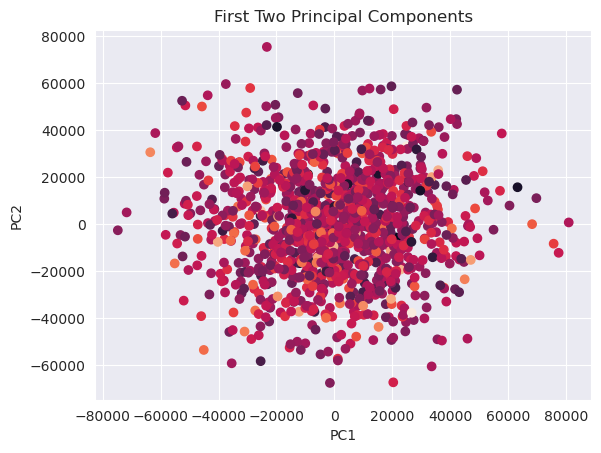

Explained Variance Ratio [0.21763384 0.20551647]


In [268]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
transform = pca.fit_transform(z_array)
corr_unsorted = X.corrwith(Y)

PC1 = transform[:,0]
PC2 = transform[:,1]

fig, ax = plt.subplots()
plot = ax.scatter(PC1, PC2, c=corr_unsorted)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("First Two Principal Components")
# for i, corr_val in enumerate(corr):
#     plt.annotate('(%s, %s)' % (i, abs(corr_val)), (PC1[i], PC2[i]))
plt.show()
print("Explained Variance Ratio %s" % pca.explained_variance_ratio_)

In [242]:
range(0, len(cosine_similarities))

range(0, 1183)

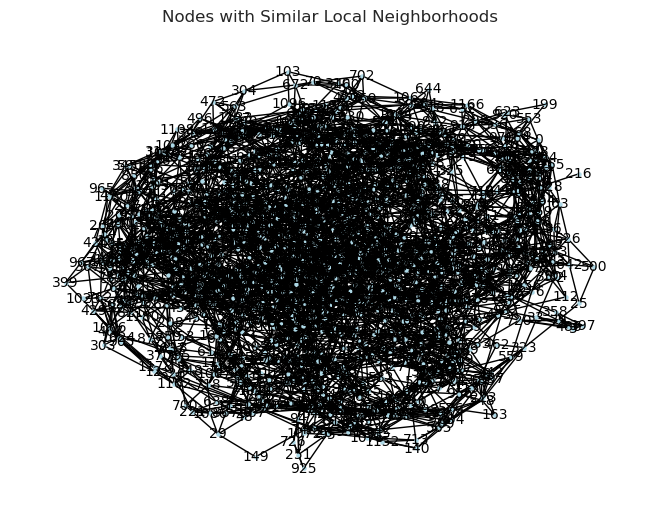

In [269]:
# Calculate similarity between nodes
node_similarities = {}
for node1 in range(0, len(cosine_similarities)):
    for node2 in range(0, len(cosine_similarities)):
        if node1 != node2:
            similarity = cosine_similarities[node1,node2]
            if similarity > 0:
                node_similarities[(node1, node2)] = similarity

# Threshold for similarity
threshold = 0.9  # adjust this threshold as needed

# Create a new graph with edges only between similar nodes
H = nx.Graph()
for (node1, node2), similarity in node_similarities.items():
    if similarity >= threshold:
        H.add_edge(node1, node2)

# Visualize the graph
pos = nx.spring_layout(H)  # You can use any layout algorithm here
nx.draw(H, pos, with_labels=True, node_color='lightblue', node_size=5, font_size=10)
plt.title('Nodes with Similar Local Neighborhoods')
plt.show()

In [253]:
H.edges()

EdgeView([(0, 27), (0, 28), (0, 36), (0, 38), (0, 43), (0, 50), (0, 51), (0, 55), (0, 56), (0, 60), (0, 61), (0, 62), (0, 75), (0, 80), (0, 134), (0, 136), (0, 148), (0, 157), (0, 182), (0, 193), (0, 197), (0, 200), (0, 214), (0, 264), (0, 266), (0, 278), (0, 290), (0, 291), (0, 292), (0, 294), (0, 299), (0, 301), (0, 305), (0, 339), (0, 346), (0, 354), (0, 375), (0, 398), (0, 411), (0, 417), (0, 419), (0, 429), (0, 434), (0, 445), (0, 446), (0, 478), (0, 485), (0, 490), (0, 501), (0, 505), (0, 511), (0, 526), (0, 527), (0, 532), (0, 546), (0, 551), (0, 552), (0, 560), (0, 561), (0, 566), (0, 570), (0, 583), (0, 591), (0, 602), (0, 603), (0, 609), (0, 611), (0, 613), (0, 616), (0, 617), (0, 623), (0, 631), (0, 635), (0, 643), (0, 656), (0, 658), (0, 659), (0, 667), (0, 673), (0, 711), (0, 714), (0, 718), (0, 719), (0, 720), (0, 736), (0, 739), (0, 749), (0, 756), (0, 760), (0, 762), (0, 773), (0, 796), (0, 813), (0, 825), (0, 846), (0, 864), (0, 882), (0, 902), (0, 924), (0, 925), (0, 

In [254]:
node_similarities[(0, 27)]

0.9031934

In [258]:
set(ppi_network.neighbors(0))
neighbors = ppi_network.neighbors(0)
neighbors_weights = [ppi_network[0][neighbor]['weight'] for neighbor in neighbors]
sum(neighbors_weights)/len(neighbors_weights)

0.6481117199004648

In [260]:
neighbors = ppi_network.neighbors(27)
neighbors_weights = [ppi_network[27][neighbor]['weight'] for neighbor in neighbors]
sum(neighbors_weights)/len(neighbors_weights)

0.6709878369949079

In [152]:
# SVM
from sklearn import svm
from sklearn import metrics
svm_model = svm.SVC(decision_function_shape='ovo')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)


0.43253968253968256